## The Matched Lattice
Knowing the RF cavities required to get to the necessary energies, and knowing the absorber lengths at each stage, the matched solenoids for each cells can be made, iterated via G4BL.

Step 1) Simulate a beam through one absorber, 40 T fields

Step 2) Acquire the momentum loss from the 1 sigma particles

Step 3) Generate matched solenoids from 4 T to 40 T to 4 T, considering the momentum loss from the absorber

Step 4) Simulate in G4BL the result from the matched solenoids

Step 5) Match solenoids between the RF cavities

Step 6) Simulate in G4BL the result from the matched cavities

Step 7) Correct the solenoids from the momentum increase in G4Beamline 

Step 8) Match the output with a field flip for the next cell

Repeat 10x

#### Preamble

In [1]:
# Packages
import numpy as np
import pandas as pd
import coolpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
from py2g4bl_match_helpers import P, CellBeamGen, compute_emit_from_phasespace, readfile, E_to_dpp_to_dE, plot_solenoid

from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ff3645","#bf3a68","#803e8b", "#4042ad","#0046d0"])
cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0046d0","#4042ad", "#803e8b","#bf3a68","#ff3645"])

In [2]:
# Global Parameters as defined by the genetic algorithm
Energies = [123.4874061 , 123.34209297, 100.41454084,  85.48562669,  74.47974494,  51.82242803,  32.01412767,  18.28142271, 17.9391355 ,  14.70422686]
AbsorberLengths = np.array([1.27736269, 1.32518469, 1.10521782, 1.13798138, 0.81575282, 0.43656683, 0.30241914, 0.10448507, 0.11920284, 0.09100977])
EnergySpreads = [5.41686927, 5.81701861, 5.25003438, 5.06819512, 5.65785391, 4.36047814, 2.39677483, 1.29680007, 1.25195259, 1.20749703]

Length_max = np.sum(AbsorberLengths)

In [3]:
# Target emittances as achieved by the simple G4BL setup
EmitT_Target = np.array([0.0002466918788431969,  0.0002026040562576625,  0.00016493170280864206,  0.00012640334072074876,  0.00010316360751668846,  8.722476322836085e-05,  6.031231528154821e-05,  4.5028352240203934e-05,  3.15684664407679e-05,  2.221710939561845e-05])
EmitL_Target = np.array([0.0018836404178010724,  0.0022763763903832462,  0.0028338086313568615,  0.003975051209763533,  0.005130191267191367,  0.006728425742772072,  0.011819326472499425,  0.020757848567312387,  0.03924855255649506,  0.07171590993046725])

In [4]:
EmitL_Target*1E3

array([ 1.88364042,  2.27637639,  2.83380863,  3.97505121,  5.13019127,
        6.72842574, 11.81932647, 20.75784857, 39.24855256, 71.71590993])

##### Define solenoid geometries

In [5]:
# Solenoid parameters
nSheet = 5
offset = 0.0

### Radius
L_radius_in  = 0.1 #[m] Low Field
L_radius_out = 0.3 #[m]
M_radius_in  = 0.1 # Matching field
M_radius_out = 0.3
H_radius_in  = 0.03 # High Field
H_radius_out = 0.09

Hcorr1_radius_out = 0.135 #outer most down and up stream correctors
Hcorr2_radius_out = 0.125 #middle  down and up stream correctors
Hcorr3_radius_out = 0.115 #inner most down and up stream correctors

### Length
L_Lsol = 1 #[m]
L_Lsol_short = 0.5 # 0.5
M_Lsol = 0.2
H_Lsol_list = [abslen + 2*0.12 for abslen in AbsorberLengths]
Hcorr_Lsol = 0.012

#### Current density ####
L_current_density = 17.  #[A/mm^2]
H_current_density = 535.3 #A mm^-2
H2_current_density = -17 #A mm^-2
M_current_density = 50 #A mm^-2

NU_matchers = 4
ND_matchers = 10

L_Lgap = 0.4
L_Hgap = 0.1
L_MUgap = 0.1
L_MDgap = 0.25+0.1
L1_pos = 0 #[m]

Define solenoid positions

In [6]:
# Setting up first cell (unique)
MU_pos_arr = [(L_Lsol/2 + L_Lgap + L_MUgap*i + M_Lsol*i + M_Lsol/2) for i in range(NU_matchers)]
H1_pos = MU_pos_arr[-1] + M_Lsol/2 + L_Hgap + H_Lsol_list[0]/2 + Hcorr_Lsol*3

H_pos_arr = np.zeros(10)
H_pos_arr[0] = H1_pos

# Finds the high field solenoid and downstream matcher positions iteratively
MD_pos_arr_all = []
for ncell in range(1, 10):
    H_pos = H_pos_arr[ncell-1]
    if H_pos != 0:
        MD_pos_arr = [(H_pos + Hcorr_Lsol*3 + H_Lsol_list[ncell-1]/2 + L_Hgap + L_MDgap*i + M_Lsol*i + M_Lsol/2) for i in range(ND_matchers)]
    H_pos_new = MD_pos_arr[-1] + M_Lsol/2 + L_Hgap + H_Lsol_list[ncell]/2 + Hcorr_Lsol*3
    MD_pos_arr_all.append(np.array(MD_pos_arr))
    H_pos_arr[ncell] = H_pos_new
MD_pos_arr_all = np.array(MD_pos_arr_all)


In [7]:
# Same but for the high-field correctors
Hcorr_rad_arr = [Hcorr1_radius_out, Hcorr2_radius_out, Hcorr3_radius_out]

HcorrU_pos_arr_all = []
HcorrD_pos_arr_all = []

for ncell in range(10):
    HcorrU_arr = [(H_pos_arr[ncell] - (H_Lsol_list[ncell]*0.5 + Hcorr_Lsol*(3-i)) + Hcorr_Lsol*0.5) for i in range(3)]
    HcorrD_arr = [(H_pos_arr[ncell] + (H_Lsol_list[ncell]*0.5 + Hcorr_Lsol*(3-i)) - Hcorr_Lsol*0.5) for i in range(3)]
    HcorrU_pos_arr_all.append(np.array(HcorrU_arr))
    HcorrD_pos_arr_all.append(np.array(HcorrD_arr))

Generate solenoid models with coolpy

In [8]:
fieldflip = np.tile([1, -1], 5)

In [9]:
# First Cell
L1 = cp.SolenoidSheet(current_density=L_current_density, radius_inner=L_radius_in, radius_outer=L_radius_out, rho=offset, L_sol=L_Lsol, nSheet=nSheet, position=L1_pos)
MU1_list = [cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MU_pos_arr[m]) for m in [0, 2, 3]]

# Matching solenoids
MD_solenoid_list = []
for ncell in range(9):
    for m in range(ND_matchers):
        MD_list = cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MD_pos_arr_all[ncell][m])
        MD_solenoid_list.append(MD_list)


In [10]:
# High field solenoids and correctors
H_solenoid_list = [cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=H_radius_out, rho=offset, L_sol=H_Lsol_list[ncell], nSheet=nSheet, position=H_pos_arr[ncell]) for ncell in range(10)]

HcorrU_solenoid_list = []
HcorrD_solenoid_list = []
for ncell in range(10):
    for corr in range(3):
        HcorrU = cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrU_pos_arr_all[ncell][corr])
        HcorrD = cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrD_pos_arr_all[ncell][corr])
        HcorrU_solenoid_list.append(HcorrU)
        HcorrD_solenoid_list.append(HcorrD)

Combine solenoid models to get analytical fields

In [11]:
MU_optimized_params = [34.07907333777548, 3.3219755405093148, 51.652979865357764]
for m, matcher in enumerate(MU1_list):
    matcher.current_density = MU_optimized_params[m]

MD1_optimized_params = np.array([27.76920748133655, -18.088449858880495, -7.37383519650483, -2.1484854222468255, -10.474393673155642, 6.957767062471406, 2.97778912938175, -0.47384451583483217, 13.109684427081453, 58.06953233879165] )
MD1_optimized_params = np.array([27.24793271568644,-17.472840845840903,-7.49011851160906,-2.2832059484376757,-10.269973570629746,7.604778119640516,2.34258111236735,-0.48055736163211965,11.619055029085757,59.77763655687829])
MD1_optimized_params = np.array([26.808273923225386, -17.469835229033713, -7.234378538624531, -2.077276294431294, -10.169785315345809, 7.496909702445462, 2.154700713367128, -0.5367349857728296, 11.3735108116485, 59.51998727810451])
MD1_optimized_params = np.array([35.71103229358868, -7.295485957534699, -12.190574294767547, 1.0893897389091456, -14.217772674701797, 3.091196668336037, 2.285241925718788, -9.16372467324308, 24.0427193045997, -45.36297472036914])
MD1_optimized_params = np.array([36.032863599859176, -7.360346148576336, -12.171028943095603, 1.0941189000056184, -14.231143139173888, 3.112122503019781, 2.277928991045071, -9.073698107689426, 24.179356776068396, -45.3974008842994])
MD1_optimized_params = np.array([35.59682398054068, -7.564106056579011, -12.110464700076378, 1.1177524157583905, -14.243282397951836, 3.1067698625930085, 2.271256312726041, -9.196280492834703, 24.292609519309373, -45.70844291411197])

for m, matcher in enumerate(MD_solenoid_list[:10]):
    matcher.current_density = (MD1_optimized_params)[m]

MD2_optimized_params = np.array([-23.062708984679535, -13.393632508869313, -1.7734390775941118, 0.15295949471782808, 11.101776961365513, -4.941337277890501, -7.967571031659366, 10.242804909180009, 8.374585892169442, 31.198200448955618] )
MD2_optimized_params = np.array([-31.591612980593435, -20.148350095265535, -1.5897448477202978, -0.06617075957675847, 12.403223412099415, -6.320489938147987, -8.837423125304284, 17.271139101426307, 7.635028639020243, 45.832044421307785] )
MD2_optimized_params = np.array([-27.088921424271916, -15.454004818520634, -1.3487381648328027, 0.07040864440515601, 13.51247718514459, -7.002601474325829, -9.401389845582546, 17.75341670854192, 9.414871030371433, 48.344830801045866])

MD2_optimized_params = np.array([-26.61973458682815, -15.532630217055132, -1.4232253491745195, 0.07388918394674199, 13.119615336903468, -7.3938811699083455, -9.50178839943556, 17.65284693535223, 9.49348083274953, 47.89823794256651] )
MD2_optimized_params = np.array([-27.22477590947216, -18.805778586671384, -1.8525622559640234, -0.6864662911746396, -18.096606678094247, -8.220764908909995, 0.0008893526980737912, 9.014035492516317, 20.318437626770756, 29.28658559134726])

for m, matcher in enumerate(MD_solenoid_list[10:20]):
    matcher.current_density = (MD2_optimized_params)[m]

MD3_optimized_params = np.array([33.433952251632135, -17.526434281082036, 13.041432445949088, 0.4692564229437426, -11.228538084004114, 8.005621815438104, 2.3585785131020436, -0.5122096895252028, 11.902161854882008, 56.33198887775717])
MD3_optimized_params = np.array([-26.726167392508284, -11.26497990523378, 2.223594776234793, 2.062572645860012, 9.591438697670325, 7.634771212495421, 2.8326851953434993, -0.5445073649129434, 11.831941260452075, -57.045471214894505])
MD3_optimized_params = np.array([11.70404185721956, 11.4531740870898, 8.300183284392803, 1.046809444076926, -1.3504210506950054, -5.542915844213153, -2.1433261782291186, 10.492485740784108, 16.834627588395175, -35.512720884511566] )
MD3_optimized_params = np.array([16.072128498635227, 11.117917965485542, 8.76776922688263, 0.11549701593930223, 0.20777044479729415, -6.24947013482447, -1.1571319187082683, 10.337641854674697, -15.749421118750298, -22.573181719319457])
for m, matcher in enumerate(MD_solenoid_list[20:30]):
    matcher.current_density = (MD3_optimized_params)[m]

for m, matcher in enumerate(MD_solenoid_list[30:40]):
    matcher.current_density = (MD2_optimized_params)[m]
for m, matcher in enumerate(MD_solenoid_list[40:50]):
    matcher.current_density = (MD3_optimized_params)[m]
for m, matcher in enumerate(MD_solenoid_list[50:60]):
    matcher.current_density = (MD2_optimized_params)[m]
for m, matcher in enumerate(MD_solenoid_list[60:70]):
    matcher.current_density = (MD3_optimized_params)[m]
for m, matcher in enumerate(MD_solenoid_list[70:80]):
    matcher.current_density = (MD2_optimized_params)[m]
for m, matcher in enumerate(MD_solenoid_list[80:90]):
    matcher.current_density = (MD3_optimized_params)[m]

[(0.0, 60.10318305000004), (-0.5, 0.5)]

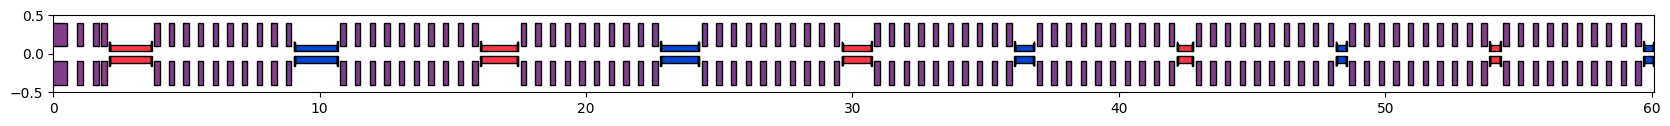

In [12]:
#Construct beamline
sol_list = [L1] + MU1_list + MD_solenoid_list + H_solenoid_list + HcorrU_solenoid_list + HcorrD_solenoid_list

mag_field = cp.MagneticField()
[mag_field.add_solenoid(solenoid) for solenoid in sol_list];

fig = plt.figure(figsize=(25,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
plt.subplots_adjust(hspace=0)

I_max = H_current_density

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)
ax1.set(xlim=(0, solenoid.position+solenoid.L_sol*4), ylim=(-0.5, 0.5))

In [13]:
matplotlib.rcParams.update({'font.size': 18})

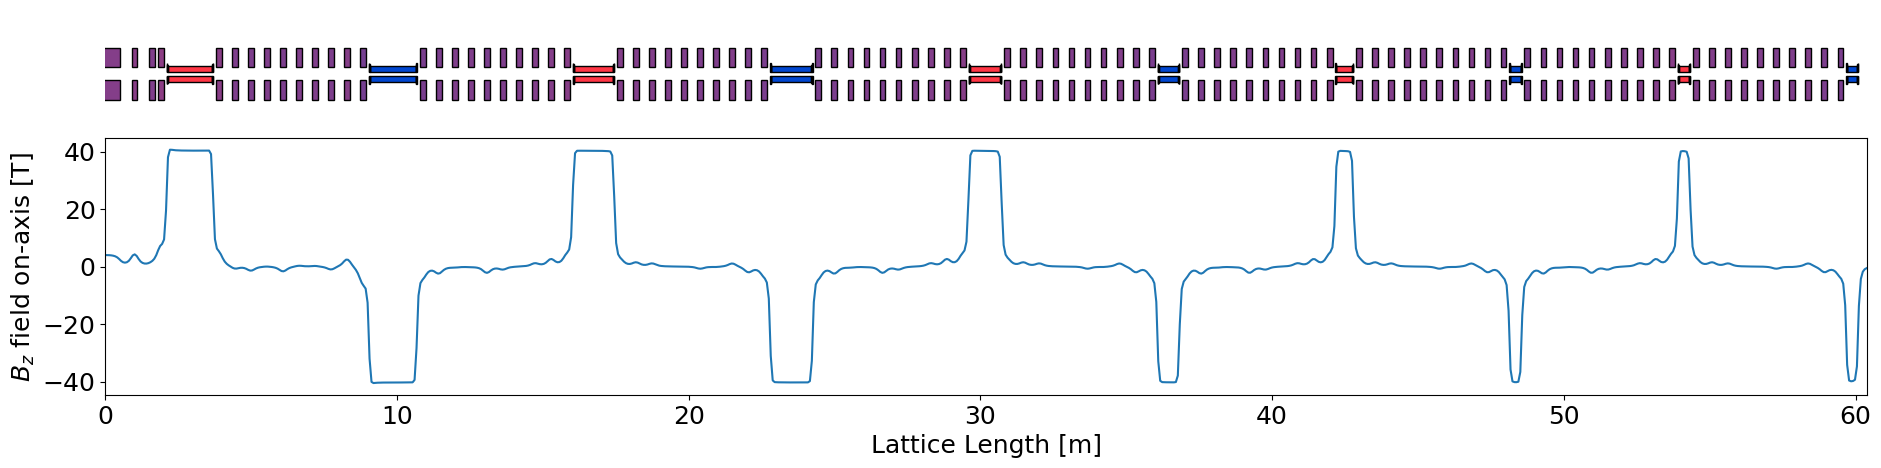

In [14]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(25,5))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[0.5, 1], width_ratios=[1, 0.0])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
plt.subplots_adjust(hspace=0)

s = np.linspace(0., H_pos_arr[-1] + 0.5, 901)
B_superposed = mag_field.superposed_field_z(s)

I_max = H_current_density
max_S = H_pos_arr[-1]+ 0.5 # max(s)
max_r = 1

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s, B_superposed)
ax2.set(ylabel=(r'$B_z$ field on-axis [T]'), xlabel="Lattice Length [m]", xlim=(0, max_S))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()

#ax1.set_title('10 Cells: Solenoid Spacing & B-Fields')
plt.show()

In [15]:
EmitT_Target = np.array([0.0003, 0.0002466918788431969,  0.0002026040562576625,  0.00016493170280864206,  0.00012640334072074876,  0.00010316360751668846,  8.722476322836085e-05,  6.031231528154821e-05,  4.5028352240203934e-05,  3.15684664407679e-05,  2.221710939561845e-05])

#### Functions for calculating beta and for optimisations

In [16]:
from scipy.integrate import solve_ivp

In [17]:
def beta_system(s, b, kappa_interp, L):
    b1, b2 = b
    db1ds = b2
    k_s = kappa_interp(s)
    db2ds = (b2**2 + 4*(1 + L**2) - 4*b1**2 * k_s**2) / (2 * b1)
    return [db1ds, db2ds]

In [18]:
def interp_beta(s, B_superposed, momentum):
    kappa = abs(cp.Gc_2 * B_superposed / momentum)
    kappa_interp = interp1d(s, kappa, kind='linear', fill_value="extrapolate")
    b0 = [1/kappa_interp(0), 0.]
    L=0
    solution = solve_ivp(fun=beta_system, t_span=[s[0], s[-1]], t_eval=s, y0=b0, args=(kappa_interp, L))
    #beta_interp = interp1d(s,  solution[:,0], kind='linear', fill_value="extrapolate")
    #betaP_interp = interp1d(s, solution[:,1], kind='linear', fill_value="extrapolate")
    return(solution.y[0],  solution.y[1])

In [19]:
def calc_beta_betap(mag_field_, s, p1, p3):
    L = 0.
    B_superposed = mag_field_.superposed_field_z(s)

    beta_interp1, betaP_interp1 = interp_beta(s, B_superposed, p1)
    beta_interp3, betaP_interp3 = interp_beta(s, B_superposed, p3)
    return([beta_interp1, betaP_interp1], [beta_interp3, betaP_interp3], B_superposed)

In [20]:
def objective(params, solenoids, s, p1_interp, p3_interp, points): 
    p1 = p1_interp(s)
    p3 = p3_interp(s)

    magfields, b1_interp_1, b1p_interp_1, b3_interp_1, b3p_interp_1  = solve_ode(solenoids, params, [p1, p3]) #Calculates the beta and beta' for one momenta set 

    B_superposed = magfields.superposed_field_z(s) # Gets the mag_field layout which has been updated from solve_ode
    B_interpol = cp.B_field_interpol(s, B_superposed) # Gets the field just at s-points 

    beta0_idal_1 = abs(p1_interp(points) / cp.Gc_2 / B_interpol(points)) # Calculates what the beta should be, considering the momentum and field
    err_b_1 = np.sum((beta0_idal_1 - b1_interp_1(points))**2) # Squared
    err_b_1 = np.sum(abs(beta0_idal_1 - b1_interp_1(points))) # Error between what the beta should be, and what the magfield gives
    
    err_b_prime_1 = np.sum((abs(b1p_interp_1(points)) )**2) # There is no ideal beta_prime, so instead we consider difference from zero
    
    weighting=50 
    err1 = err_b_1 + weighting*err_b_prime_1

    beta0_idal_3 = abs(p3_interp(points) / cp.Gc_2 / B_interpol(points))# Calculates what the beta should be, considering the momentum and field
    err_b_3 = np.sum((beta0_idal_3 - b3_interp_1(points))**2) # Squared
    err_b_3 = np.sum(abs(beta0_idal_3 - b3_interp_1(points))) # Error between what the beta should be, and what the magfield gives
    err_b_prime_3 = np.sum((abs(b3p_interp_1(points)) )**2)# There is no ideal beta_prime, so instead we consider difference from zero

    err3 = err_b_3 + weighting*err_b_prime_3

    weighting_3_1 = 1
    err = weighting_3_1*err3 + err1# + err2

    print(params.tolist(), err)

    return err

In [21]:
def objective(params, solenoids, s, p1_interp, p3_interp, points):
    p1 = p1_interp(s)
    p3 = p3_interp(s)

    magfields, b1, b1p, b3, b3p  = solve_ode(solenoids, params, [p1, p3], s) #Calculates the beta and beta' for one momenta set 

    B_superposed = magfields.superposed_field_z(s) # Gets the mag_field layout which has been updated from solve_ode
    B_interpol = cp.B_field_interpol(s, B_superposed) # Gets the field just at s-points 

    beta0_idal_1 = abs(p1_interp(points) / cp.Gc_2 / B_interpol(points)) # Calculates what the beta should be, considering the momentum and field
    
    b1_points = np.interp(points, s, b1)
    err_b_1 = np.sum(abs(beta0_idal_1 - b1_points)) # Error between what the beta should be, and what the magfield gives
    b1p_points = np.interp(points, s, b1p)
    err_b_prime_1 = np.sum((abs(b1p_points) )**2) # There is no ideal beta_prime, so instead we consider difference from zero
    
    weighting=50 
    err1 = err_b_1 + weighting*err_b_prime_1

    beta0_idal_3 = abs(p3_interp(points) / cp.Gc_2 / B_interpol(points))# Calculates what the beta should be, considering the momentum and field
    
    b3_points = np.interp(points, s, b3)
    err_b_3 = np.sum(abs(beta0_idal_3 - b3_points)) # Error between what the beta should be, and what the magfield gives
    b3p_points = np.interp(points, s, b3p)
    err_b_prime_3 = np.sum((abs(b3p_points) )**2)# There is no ideal beta_prime, so instead we consider difference from zero

    err3 = err_b_3 + weighting*err_b_prime_3

    weighting_3_1 = 1
    err = weighting_3_1*err3 + err1# + err2

    print(params.tolist(), err)

    return err

In [22]:
def solve_ode(solenoids, params, Momentum, s):
    L = 0

    for m, matcher in enumerate(solenoids):
        matcher.current_density = params[m]

    mag_field_ = cp.MagneticField()
    [mag_field_.add_solenoid(solenoid) for solenoid in sol_list]

    B_superposed = mag_field_.superposed_field_z(s)
    b1, b1_p = interp_beta(s, B_superposed, Momentum[0])
    b3, b3_p = interp_beta(s, B_superposed, Momentum[1])

    return mag_field_, b1, b1_p, b3, b3_p

In [26]:
def compute_emit_from_phasespace(beam):
    m_mu = 0.105658375
    c= cp.c
    ref_charge = 0.299792458
    X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
    BZ = beam['Bz']
    E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5

    filt = True

    if filt:
        # Stack the variables for easier filtering
        data = np.stack([X, PX, Y, PY, T, E])
        # Calculate the mean and standard deviation of each variable
        means = np.mean(data, axis=1)
        stds = np.std(data, axis=1)
        # Identify high amplitude particles (above 5 sigma)
        sigma = 5
        filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
        # Filter the data
        filtered_data = data[:, filtered_indices]
        
        # Compute the covariance matrix of the filtered data
        Cov = np.cov(filtered_data)
    else:
        Cov = np.cov([X,PX,Y,PY,T,E])

    Cov4D = Cov[0:4, 0:4]
    Covz = Cov[4:6, 4:6]
    
    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 
    emitZ = (np.linalg.det(Covz) )**(0.5) * c / cp.m_mu
    
    Pzaverage = np.mean(PZ)
    Bzaverage = np.mean(BZ)
    emi4D_geo = emi4D_ * m_mu / Pzaverage
    
    xpy = Cov[0][3]
    ypx = Cov[1][2]
    xx = Cov[0][0]
    yy = Cov[2][2]
    
    L_ = (Bzaverage*ref_charge*0.5*(xx + yy) - (ypx - xpy )) * 0.5 / m_mu / emi4D_
    
    try:
        Cov4D_inv = np.linalg.inv(Cov4D)
    except np.linalg.LinAlgError:
        print(filtered_data)
        return np.nan, np.nan, np.nan
    U = np.stack(filtered_data[:4], axis=1)
    A = np.einsum('ij,jk,ik->i', U , Cov4D_inv, U ) * emi4D_geo

    ampsq_sp = A
    #ampsq_sp = (term1 + term2 + term3 +term4)/m_mu

    CovL = np.cov([np.array(filtered_data[4]), np.array(filtered_data[5]), ampsq_sp])
    AAT = CovL[2,2]
    emiL_ = (np.linalg.det(CovL) )**(0.5) / m_mu * ref_charge / (AAT**0.5)
    return emi4D_, emiL_, emitZ, L_


### Create Lattice File

In [27]:
FCLattice = pd.DataFrame(columns=['element','name','centre','length','material','inner radius','outer radius','field on-axis','current density','nsheets','gradient','frequency','phase','wedge angle'])

In [28]:
FCLattice.loc[0] = pd.Series({'element':'solenoid', 'name':f'L0', 'centre':L1.position, 'length':L1.L_sol*1E3, 'inner radius':L1.radius_inner, 'outer radius':L1.radius_outer, 'field on-axis':4, 'current density':L1.current_density, 'nsheets':L1.nSheet})
for i in range(1,10):
    FCLattice.loc[i]    = pd.Series({'element':'absorber', 'name':f'abs{i+1}', 'centre':H_pos_arr[i], 'length':AbsorberLengths[i]*1E3, 'material':'LH2', 'inner radius':0, 'outer radius':25})
    FCLattice.loc[i+10] = pd.Series({'element':'solenoid', 'name':f'H{i+1}', 'centre':H_pos_arr[i], 'length':H_solenoid_list[i].L_sol*1E3, 'inner radius':30, 'outer radius':90, 'field on-axis':40, 'current density':fieldflip[i]*H_solenoid_list[i].current_density, 'nsheets':3})
for u, hcorr in enumerate(HcorrU_solenoid_list):
    FCLattice.loc[u+20] = pd.Series({'element':'solenoid', 'name':f'H{u//3+1}corr{u%3+1}_U', 'centre':hcorr.position, 'length':hcorr.L_sol*1E3, 'inner radius':hcorr.radius_inner, 'outer radius':hcorr.radius_outer, 'current density':fieldflip[u]*hcorr.current_density, 'nsheets':3})
for u, hcorr in enumerate(HcorrD_solenoid_list):
    FCLattice.loc[u+50] = pd.Series({'element':'solenoid', 'name':f'H{u//3+1}corr{u%3+1}_D', 'centre':hcorr.position, 'length':hcorr.L_sol*1E3, 'inner radius':hcorr.radius_inner, 'outer radius':hcorr.radius_outer, 'current density':fieldflip[u]*hcorr.current_density, 'nsheets':3})
for md, matcher in enumerate(MD_solenoid_list):
    FCLattice.loc[md+80] = pd.Series({'element':'solenoid', 'name':f'MD{md//10+1}_{md%10+1}', 'centre':matcher.position, 'length':matcher.L_sol*1E3, 'inner radius':matcher.radius_inner, 'outer radius':matcher.radius_outer, 'current density':matcher.current_density, 'nsheets':10})
for mu, matcher in enumerate(MU1_list):
    FCLattice.loc[mu+170] = pd.Series({'element':'solenoid', 'name':f'MU{mu+1}', 'centre':matcher.position, 'length':matcher.L_sol*1E3, 'inner radius':matcher.radius_inner, 'outer radius':matcher.radius_outer, 'current density':matcher.current_density, 'nsheets':10})


IndexError: index 10 is out of bounds for axis 0 with size 10

In [35]:
rf_rot_grad_arr = [2*32, 2*32, 2*15,  60,  150, 30, 30, 30, 30]
rf_grad_arr     = [32,     17,   18,  25,   10, 20, 15, 15, 15]
acc_freq_arr    = [0,       0,    0,  0,     0, 0, 0, 0, 0]
rot_freq_arr    = [50,     50,   50,  50,   50, 50, 50, 50, 50]
acc_phase_arr   = [50,     50,   50,  10,   10, 50, 50, 50, 50]


rf_count = 0
for rf, Matcher in enumerate(MD_solenoid_list):
    rf_no, cell_no = rf%10, rf//10
    if rf_no >= 9: #There is no 10th solenoid
        pass
    else:
        rf1_pos= Matcher.position+0.25+0.05/2
        if rf_no < 4: #Rotational cavities
            FCLattice.loc[rf_count+173] = pd.Series({'element':'rf_pillbox', 'name':f'rf{cell_no+1}_{rf_no+1}', 'centre':rf1_pos, 'inner radius':160, 'gradient':rf_rot_grad_arr[cell_no], 'frequency':rot_freq_arr[cell_no], 'phase':0})
            rf_count += 1
        if rf_no >= 4:
            FCLattice.loc[rf_count+173] = pd.Series({'element':'rf_pillbox', 'name':f'rf{cell_no+1}_{rf_no+1}', 'centre':rf1_pos, 'length':250, 'inner radius':160, 'gradient':rf_grad_arr[cell_no], 'frequency':acc_freq_arr[cell_no], 'phase':acc_phase_arr[cell_no]})
            rf_count += 1

In [37]:
FCLattice.to_csv('FinalCooling_10Cell_Ver0.00_281025.csv')

In [ ]:
FCLattice

,element,name,centre,length,material,inner radius,outer radius,field on-axis,current density,nsheets,gradient,frequency,phase,wedge angle
0,absorber,abs1,2.894681,1277.36269,LH2,0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,solenoid,H1,2.894681,1517.36269,NaN,30,90,40,535.3,3,NaN,NaN,NaN,NaN
1,absorber,abs2,9.857955,1325.18469,LH2,0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,solenoid,H2,9.857955,1565.18469,NaN,30,90,40,-535.3,3,NaN,NaN,NaN,NaN
2,absorber,abs3,16.735156,1105.21782,LH2,0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,rf_pillbox,rf9_5,57.007173,250,NaN,160,NaN,NaN,NaN,NaN,15,0,50,NaN
250,rf_pillbox,rf9_6,57.557173,250,NaN,160,NaN,NaN,NaN,NaN,15,0,50,NaN
251,rf_pillbox,rf9_7,58.107173,250,NaN,160,NaN,NaN,NaN,NaN,15,0,50,NaN
252,rf_pillbox,rf9_8,58.657173,250,NaN,160,NaN,NaN,NaN,NaN,15,0,50,NaN


#### G4Beamline setup

Definitions, absorbers and coils

In [29]:
setup = f'''
g4ui when=4 "/vis/viewer/set/background 1 1 1"
param disable=Decay   #Whether muons decay
param stochastics=1
physics QGSP_BIC disable=$disable
param cell_end={(H_pos_arr[-1]+H_Lsol_list[-1]/2)*1E3}
param zstep=50
'''

absorber_list = []
highcoil_list = []
for cellno in [0,1,2,3,4,5,6,7,8,9]:
    absorbers = f'''
tube abs{cellno} length={AbsorberLengths[cellno]*1E3} material=LH2 innerRadius=0 outerRadius=25 color=1,1,1,1
place abs{cellno} z={H_pos_arr[cellno]*1E3:.2f}'''
    absorber_list.append(absorbers)

for cellno in range(10):
    highcoils = f'''
coil H{cellno+1}_C innerRadius=30 outerRadius=90 length={H_solenoid_list[cellno].L_sol*1E3} nSheets=3 tolerance=1 maxZ=7000'''
    highcoil_list.append(highcoils)

coils = f'''
### Low Field
coil L1_C innerRadius=100 outerRadius=300 length={L1.L_sol*1E3} nSheets=3 tolerance=1 maxZ=7000

### High Field
coil Hcorr1_C innerRadius=30 outerRadius=135 length=12 nSheets=3 tolerance=1 maxZ=7000
coil Hcorr2_C innerRadius=30 outerRadius=125 length=12 nSheets=3 tolerance=1 maxZ=7000
coil Hcorr3_C innerRadius=30 outerRadius=115 length=12 nSheets=3 tolerance=1 maxZ=7000

# Matchers
coil M_C innerRadius=100 outerRadius={M_radius_out*1E3} length={M_Lsol*1E3} nSheets=10 tolerance=1 maxZ=7000
'''

low_solenoid = f'''
solenoid L1 coil=L1_C current=17.0 color=0.929,0.616,0.035,1
place L1 z=0'''


High field solenoids and high field corrections

In [30]:
high_solenoids = []
for cellno, Hsol in enumerate(H_solenoid_list):
    if Hsol.current_density > 0:
           color='1,0,0,0.5'
    else:
           color='0,0,1,0.5'
    highsolenoid = f'''
solenoid H{cellno+1} coil=H{cellno+1}_C current={Hsol.current_density} color={color}
place H{cellno+1} z={Hsol.position*1E3}'''
    high_solenoids.append(highsolenoid)
    
HCorrU_solenoids = []
for u, hcorr in enumerate(HcorrU_solenoid_list):
        if hcorr.current_density > 0:
                color='1,0,0,0.5'
        else:
                color='0,0,1,0.5'
        HCU = f'''
solenoid H{u//3+1}corr{u%3+1}_U coil=Hcorr{u%3+1}_C current={hcorr.current_density} color={color}
place H{u//3+1}corr{u%3+1}_U z={hcorr.position*1E3}'''
        HCorrU_solenoids.append(HCU)
        
HCorrD_solenoids = []
for d, hcorr in enumerate(HcorrD_solenoid_list):
        if hcorr.current_density > 0:
                color='1,0,0,0.5'
        else:
                color='0,0,1,0.5'
        HCD = f'''
solenoid H{d//3+1}corr{d%3+1}_U coil=Hcorr{d%3+1}_C current={hcorr.current_density} color={color}
place H{d//3+1}corr{d%3+1}_U z={hcorr.position*1E3}'''
        HCorrD_solenoids.append(HCD)

Matching solenoids upstream and downstream/rf

In [31]:
MU_pos_arr = [1.0, 1.6, 1.9000000000000004]
MU_solenoids = []
for i in range(3):
    MU = f'''
solenoid MU{i+1} coil=M_C current={MU1_list[i].current_density} color=1,0,1,1
place MU{i+1} z={MU_pos_arr[i]*1E3}'''
    MU_solenoids.append(MU)

MD_solenoids = []
for md, Matcher in enumerate(MD_solenoid_list):
    MD = f'''
solenoid MD{md//10+1}_{md%10+1} coil=M_C current={Matcher.current_density} color=1,0,1,1
place MD{md//10+1}_{md%10+1} z={Matcher.position*1E3}'''
    MD_solenoids.append(MD)


RF definitions

Single reference particle tracking

In [32]:
N = 10000

In [33]:
track_p1 = f'''
param ref_p={P((Energies[0]-EnergySpreads[0]/2)*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p1.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={1} # user provided file with particle data
trackcuts keep=mu+

param do_field_map=1
if $do_field_map
  fieldntuple field_out format=ascii filename='Cell10_FieldmapCell' z=0,$cell_end,$zstep
endif
'''

track_p2 = f'''
param ref_p={P((Energies[0]+EnergySpreads[0]/2)*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p2.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={1} # user provided file with particle data
trackcuts keep=mu+

param do_field_map=1
if $do_field_map
  fieldntuple field_out format=ascii filename='Cell10_FieldmapCell' z=0,$cell_end,$zstep
endif
'''

track_all = f'''
param kinetic_energy={Energies[0]}
param ref_p={P(Energies[0]*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_{N}.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={N} # user provided file with particle data
trackcuts keep=mu+

'''

In [34]:
P(Energies[0]*1E6)*1E-6

np.float64(203.33247877337413)

In [35]:
rf_rot_grad_arr = [2*32, 150, 15, 15, 15, 40, 40, 40, 40]
rf_grad_arr = [32, 20, 45, 30, 25, 20, 15, 15, 15]
acc_freq_arr = [0, 0, 50, 0, 0, 0, 0, 0, 0]
rot_freq_arr = [50, 50, 50, 0, 0, 0, 0, 0, 0]
acc_phase_arr = [50, 50, 50, 50, 50, 50, 50, 50, 50]

freq = 10
phase = 50
n_cavities = 9

rf_list = []
for rf, Matcher in enumerate(MD_solenoid_list):
    rf_no, cell_no = rf%10, rf//10
    if rf_no >= 9: #There is no 10th solenoid
        pass
    else:
        rf1_pos= Matcher.position+0.25+0.05/2

        if cell_no >= 3: #Additional rotational component of 180 degrees
            if rf_no ==0: #Rotational cavities
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250 maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={180} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            elif rf_no < 4:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250 maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            elif rf_no >=4:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250 maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)

        else: # No additional 180 degrees component
            if rf_no < 4: #Rotational cavities
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250 maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={0} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            else:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250 maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)

In [36]:
# Without timeOffset=0
rf_rot_grad_arr = [2*32, 2*32, 2*15,  60,  150, 30, 30, 30, 30]
rf_grad_arr     = [32,     17,   18,  25,   10, 20, 15, 15, 15]
acc_freq_arr    = [0,       0,    0,  0,     0, 0, 0, 0, 0]
rot_freq_arr    = [50,     50,   50,  50,   50, 50, 50, 50, 50]
acc_phase_arr   = [50,     50,   50,  10,   10, 50, 50, 50, 50]

# With timeOffset=0
rf_rot_grad_arr = [32,     0,    0,   15,    5, 0, 0, 0, 0]
rf_grad_arr     = [15,     16,   18,  15,   10, 20, 15, 15, 15]
acc_freq_arr    = [0,       0,    0,  0,     0, 0, 0, 0, 0]
rot_freq_arr    = [50,     50,   50,  20,   20, 50, 50, 50, 50]
acc_phase_arr   = [50,     50,   50,  50,   5, 50, 50, 50, 50]
rot_phase_arr   = [0,     0,     0,  10,  0, 0, 0, 0, 0]

rf_list = []
for rf, Matcher in enumerate(MD_solenoid_list):
    rf_no, cell_no = rf%10, rf//10

    if cell_no < 4: #Rotation first, then acceleration
        if rf_no >= 9: #There is no 10th solenoid
            pass
        else:
            rf1_pos= Matcher.position+0.25+0.05/2
            if rf_no < 4: #Rotational cavities
                RF = f'''
    pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  timeOffset=0 maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={rot_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
    place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            if rf_no >= 4:
                RF = f'''
    pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  timeOffset=0 maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
    place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)
    elif cell_no >= 4:
        if rf_no >= 9: #There is no 10th solenoid
            pass
        else:
            rf1_pos= Matcher.position+0.25+0.05/2
            if rf_no >= 4: #Rotational cavities
                RF = f'''
    pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  timeOffset=0 maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={rot_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
    place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            if rf_no < 4:
                RF = f'''
    pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  timeOffset=0 maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
    place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)

Write and run g4bl file

In [215]:
with open(f'Cell10_Ver0.00_220825.g4bl', "w") as f:
        f.write(setup)
        f.write(coils)
        f.write(low_solenoid)
        for cellno in range(len(absorber_list)):
                f.write(absorber_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(highcoil_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(high_solenoids[cellno])
        f.write('''
                ''')
        for hcorr in HCorrU_solenoids:
                f.write(hcorr)
        for hcorr in HCorrD_solenoids:
                f.write(hcorr)
        f.write('''
                ''')
        for MU in MU_solenoids:
                f.write(MU)
        f.write('''
                ''')
        for MD in MD_solenoids:
                f.write(MD)
        f.write('''
                ''')
        for rf in rf_list:
                f.write(rf)
        f.write('''
                ''')
        #f.write(track_all)
        f.write(track_p1)
        #f.write(track_p2)

subprocess.run([r"C:\Program Files\Muons, Inc\G4beamline\bin\g4bl.exe", f"Cell10_Ver0.00_220825.g4bl"])

CompletedProcess(args=['C:\\Program Files\\Muons, Inc\\G4beamline\\bin\\g4bl.exe', 'Cell10_Ver0.00_220825.g4bl'], returncode=0)

In [216]:
with open(f'Cell10_Ver0.00_220825.g4bl', "w") as f:
        f.write(setup)
        f.write(coils)
        f.write(low_solenoid)
        for cellno in range(len(absorber_list)):
                f.write(absorber_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(highcoil_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(high_solenoids[cellno])
        f.write('''
                ''')
        for hcorr in HCorrU_solenoids:
                f.write(hcorr)
        for hcorr in HCorrD_solenoids:
                f.write(hcorr)
        f.write('''
                ''')
        for MU in MU_solenoids:
                f.write(MU)
        f.write('''
                ''')
        for MD in MD_solenoids:
                f.write(MD)
        f.write('''
                ''')
        for rf in rf_list:
                f.write(rf)
        f.write('''
                ''')
        #f.write(track_all)
        #f.write(track_p1)
        f.write(track_p2)

subprocess.run([r"C:\Program Files\Muons, Inc\G4beamline\bin\g4bl.exe", f"Cell10_Ver0.00_220825.g4bl"])

CompletedProcess(args=['C:\\Program Files\\Muons, Inc\\G4beamline\\bin\\g4bl.exe', 'Cell10_Ver0.00_220825.g4bl'], returncode=0)

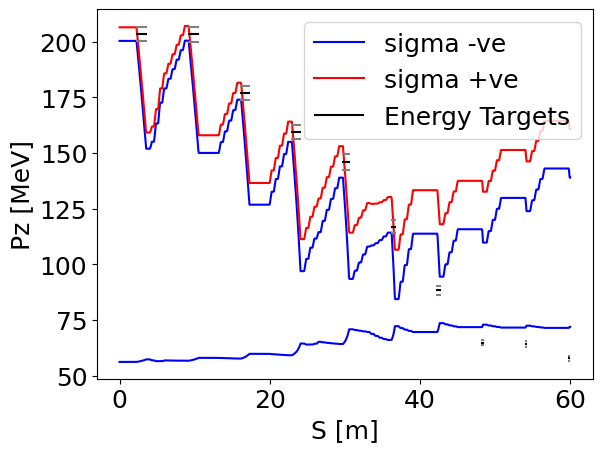

In [37]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p1.txt', 'for009')
sol_df1 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p2.txt', 'for009')
sol_df2 = pd.DataFrame(track_dict)

plt.plot(sol_df1[sol_df1.IEVT==0].Z, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'sigma -ve')
plt.plot(sol_df2[sol_df2.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'r', label=f'sigma +ve')

plt.ylabel('Pz [MeV]'), plt.xlabel('S [m]')

for i in range(10):
    plt.hlines(P((Energies[i]-EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P((Energies[i]+EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k', label='Energy Targets')
plt.legend()


plt.plot(sol_df1[sol_df1.IEVT==0].Z, 50 - sol_df1[sol_df1.IEVT==0].Pz*1E3 + sol_df2[sol_df2.IEVT==0].Pz*1E3, 'b', label=f'diff sigma')

(Text(0, 0.5, 'Pz [MeV]'), Text(0.5, 0, 'S [m]'))

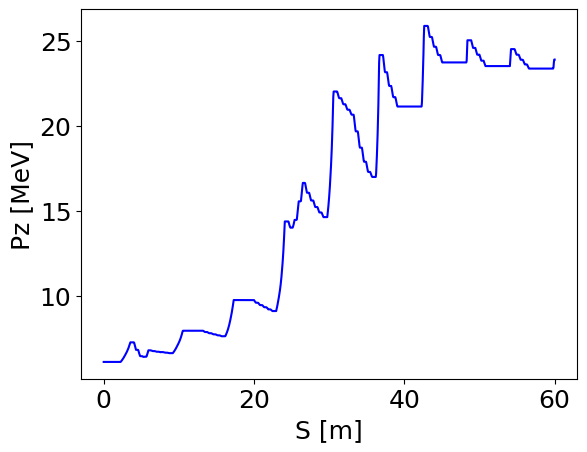

In [179]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p1.txt', 'for009')
sol_df1 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p2.txt', 'for009')
sol_df2 = pd.DataFrame(track_dict)

plt.plot(sol_df1[sol_df1.IEVT==0].Z, - sol_df1[sol_df1.IEVT==0].Pz*1E3 + sol_df2[sol_df2.IEVT==0].Pz*1E3, 'b', label=f'diff sigma')

plt.ylabel('Pz [MeV]'), plt.xlabel('S [m]')


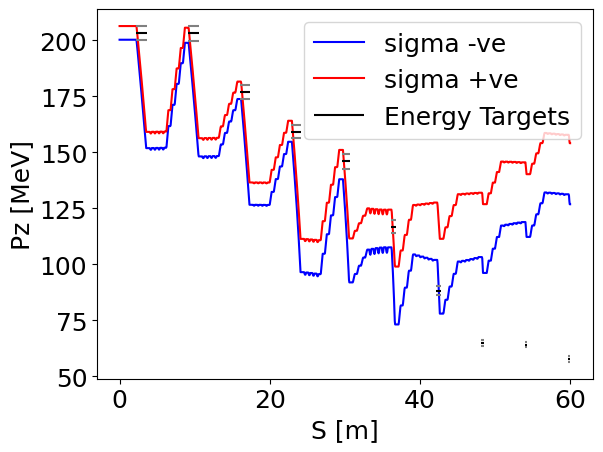

In [42]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p1.txt', 'for009')
sol_df1 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p2.txt', 'for009')
sol_df2 = pd.DataFrame(track_dict)

plt.plot(sol_df1[sol_df1.IEVT==0].Z, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'sigma -ve')
plt.plot(sol_df2[sol_df2.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'r', label=f'sigma +ve')

plt.ylabel('Pz [MeV]'), plt.xlabel('S [m]')

for i in range(10):
    plt.hlines(P((Energies[i]-EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P((Energies[i]+EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k', label='Energy Targets')
plt.legend()

In [38]:
pid1_PMev, pid3_PMev, s1_particle, s2_particle = sol_df1[sol_df1.IEVT==0].Pz*1E3, sol_df2[sol_df2.IEVT==0].Pz*1E3, sol_df1[sol_df1.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Z
# With linear decrease
p1_interp = interp1d(s1_particle, 1E-3*pid1_PMev, kind='linear', fill_value="extrapolate")
p3_interp = interp1d(s2_particle, 1E-3*pid3_PMev, kind='linear', fill_value="extrapolate")

In [121]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_{N}.txt', 'for009')
sol_df = pd.DataFrame(track_dict)

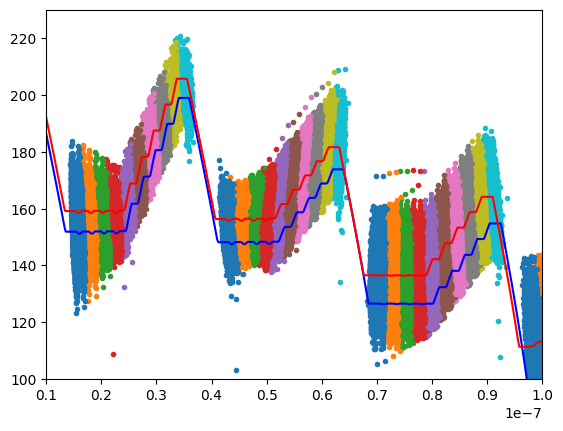

In [122]:
for md_solenoid in MD_solenoid_list:
    Z = md_solenoid.position
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')], 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')
    
for md_solenoid in MD_solenoid_list:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')], 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')

plt.ylim(100, 230)
plt.xlim(1E-8, 10E-8)

plt.plot(sol_df1[sol_df1.IEVT==0]['T'], sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'sigma -ve')
plt.plot(sol_df2[sol_df2.IEVT==0]['T'], sol_df2[sol_df2.IEVT==0].Pz*1E3, 'r', label=f'sigma +ve')

In [128]:
Ez_arr = []
dEz_arr = []
dpp_arr = []
Transmission = []
Z_unique = sol_df.Z.unique()

for Zend in sol_df.Z.unique():
    pz_dist = np.array(sol_df['Pz'][(sol_df.Z == Zend)])*1E3
    Ez_dist = np.sqrt(pz_dist**2 + 105.65**2) - 105.65
    
    Ez_arr.append(np.mean(Ez_dist))
    dEz_arr.append(np.std(Ez_dist))
    dpp_arr.append(np.std(pz_dist)/np.mean(pz_dist))
    
    No_particles = len(sol_df['IEVT'][(sol_df.Z == Zend)].unique())
    Transmission.append(No_particles)

Ez_arr, dEz_arr = np.array(Ez_arr), np.array(dEz_arr)

In [123]:
emitT_arr, emitL_arr, emitz_arr, Z_arr = [], [], [], []
transmission_arr = []
Z_unique = sol_df.Z.unique()
for Z in Z_unique:
    try:
        emitT, emitL, emitZ, L_ = compute_emit_from_phasespace(sol_df[(sol_df['Z'] == Z) & (sol_df['IEVT'] <100000)])
        emitT_arr.append(emitT), emitL_arr.append(emitL), emitz_arr.append(emitZ)
        Z_arr.append(Z)
        transmission_arr.append(len(sol_df[(sol_df['Z'] == Z) & (sol_df['IPTYP'] == 2)]))
    except ValueError:
        print(Z)

(0.0, 20.0)

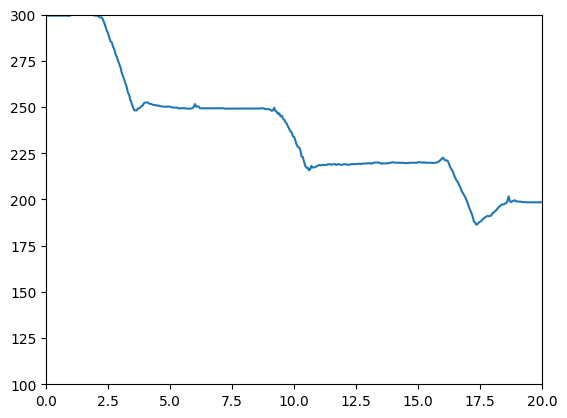

In [124]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(100, 300)
plt.xlim(0,20)

C:\Users\accel\AppData\Local\Temp\ipykernel_7204\2729283746.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


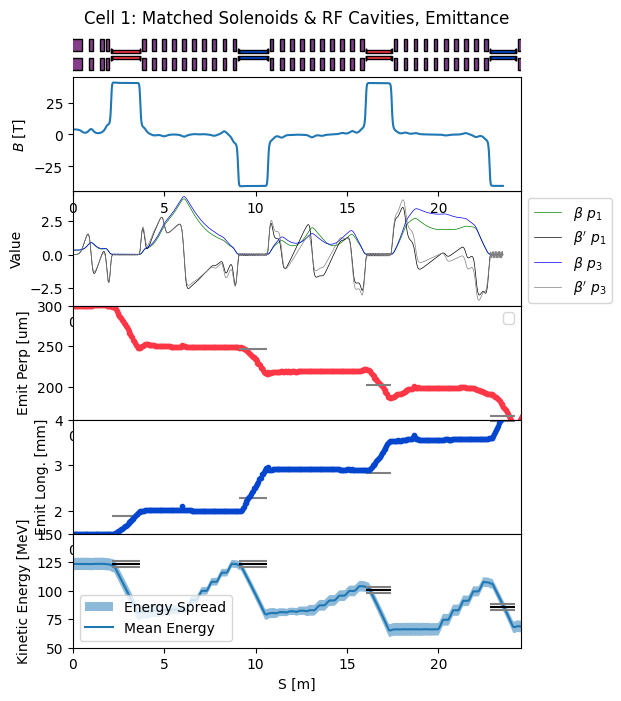

In [125]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(7,8))
gs = mpl.gridspec.GridSpec(6, 2, height_ratios=[0.4, 1, 1,1,1,1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax4 = fig.add_subplot(gs[4])
ax3 = fig.add_subplot(gs[6])
ax5 = fig.add_subplot(gs[8])
ax2 = fig.add_subplot(gs[10])
ax6 = fig.add_subplot(gs[2])

plt.subplots_adjust(hspace=0)

I_max = H_current_density

ncell_match = 3
s_start, s_end = 0, H_solenoid_list[ncell_match].position
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 
max_S = s_end
max_r = 1

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax1.set(xlim=(0, max_S+1), ylim=(-0.6, 0.6), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.fill_between(Z_unique, Ez_arr-dEz_arr, Ez_arr+dEz_arr, alpha=0.5, label='Energy Spread')
ax2.plot(Z_unique, Ez_arr, label='Mean Energy')
for i in range(10):
    ax2.hlines(Energies[i]-EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax2.hlines(Energies[i]+EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax2.hlines(Energies[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
#ax2.fill_between((H2_pos-1, H2_pos), (Energies[1]-EnergySpreads[1]/2, Energies[1]-EnergySpreads[1]/2), (Energies[1]+EnergySpreads[1]/2,Energies[1]+EnergySpreads[1]/2) , color='g', alpha=0)
ax2.set(xlim=(0, max_S+1), ylim=(50,150), xlabel='S [m]', ylabel='Kinetic Energy [MeV]')
ax2.legend(loc='lower left')

ax1.set_title('Cell 1: Matched Solenoids & RF Cavities, Emittance')

ax3.plot(Z_arr, np.array(emitT_arr)*1E6, '.', color=cmap(0))
ax3.set(xlabel='Z [m]',ylabel='Emit Perp [um]', ylim=(160,300), xlim=(0, max_S+1))

for i in range(10):
    ax3.hlines(1e6*EmitT_Target[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax5.hlines(1e3*EmitL_Target[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')

ax3.legend()

ax5.plot(Z_arr, np.array(emitL_arr)*1E3, '.', color=cmap(0.99))
ax5.set(xlabel='Z [m]',ylabel='Emit Long. [mm]', xlim=(0, max_S+1), ylim=(1.5, 4))


Mag_field = cp.MagneticField()
[Mag_field.add_solenoid(solenoid) for solenoid in sol_list];

p1 = p1_interp(s)
p3 = p3_interp(s)
[beta_interp1, betaP_interp1], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(Mag_field, s, p1, p3)

# Plotting the results
ax4.plot(s, beta_interp1, c='g', lw=0.5, label=r'$\beta \ p_1$')
ax4.plot(s, betaP_interp1, c='k', lw=0.5,label=r'$\beta^{\prime} \ p_1$')
ax4.plot(s, beta_interp3, c='b', lw=0.5, label=r'$\beta \ p_3$')
ax4.plot(s, betaP_interp3, c='grey', lw=0.5,label=r'$\beta^{\prime} \ p_3$')
ax4.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S+1))
ax4.legend(bbox_to_anchor=(1.0, 1.0))


ax6.plot(s, B_superposed)
ax6.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S+1))

ax1.set_axis_off()

plt.show()

Text(0.5, 0, 'Z [m]')

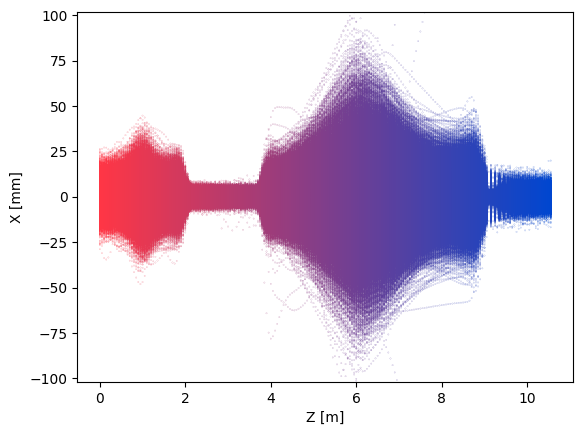

In [ ]:
plt.scatter(sol_df.Z, sol_df.X*1E3, s=0.01, c=sol_df.Z, cmap=cmap)
std_lim = 8
xlimmin, xlimmax = sol_df.X.mean()-std_lim*sol_df.X.std(), sol_df.X.mean()+std_lim*sol_df.X.std()
plt.ylim(xlimmin*1E3, xlimmax*1E3)
plt.ylabel('X [mm]')
plt.xlabel('Z [m]')

## Matching Time

In [46]:
ncell_match = 4
s_start, s_end = 0, H_solenoid_list[ncell_match].position
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 
matching_solenoids = MD_solenoid_list[10*(ncell_match-1):10*ncell_match]

In [47]:
N_magnets = 10

bounds = np.tile([-30, 30], [N_magnets, 1]) #  np.reshape(np.append(np.tile([-60, 60], [9, 1]),  np.array([-60, -5])), [10,2]) # 
options = {'maxiter': 10000}

opt_point = H_solenoid_list[ncell_match].position
points = np.array([opt_point-0.7, opt_point-0.6, opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5, opt_point+0.6, opt_point+0.7])

In [59]:
optimized_params = np.array([-10.234856758196287, -9.952104851523318, -5.741426834822564, -0.9205631789602097, 0.4004842822089942, -0.0654540412485238, 4.759789885904203, -6.906636925204353, -15.702493843198779, -21.9355571072905])
result = minimize(objective, optimized_params, args=(matching_solenoids, s, p1_interp, p3_interp, points), method='nelder-mead', jac=None, bounds=bounds, options=options, tol=1e-4)
optimized_params = result.x
print('Result ', optimized_params.tolist())

[-10.234856758196287, -9.952104851523318, -5.741426834822564, -0.9205631789602097, 0.4004842822089942, -0.0654540412485238, 4.759789885904203, -6.906636925204353, -15.702493843198779, -21.9355571072905] 3946.1329794169405
[-10.746599596106101, -9.952104851523318, -5.741426834822564, -0.9205631789602097, 0.4004842822089942, -0.0654540412485238, 4.759789885904203, -6.906636925204353, -15.702493843198779, -21.9355571072905] 3733.174286115516
[-10.234856758196287, -10.449710094099483, -5.741426834822564, -0.9205631789602097, 0.4004842822089942, -0.0654540412485238, 4.759789885904203, -6.906636925204353, -15.702493843198779, -21.9355571072905] 4773.496371589807
[-10.234856758196287, -9.952104851523318, -6.0284981765636925, -0.9205631789602097, 0.4004842822089942, -0.0654540412485238, 4.759789885904203, -6.906636925204353, -15.702493843198779, -21.9355571072905] 5099.15686209064
[-10.234856758196287, -9.952104851523318, -5.741426834822564, -0.9665913379082202, 0.4004842822089942, -0.06545404

In [ ]:
MU_optimized_params = [34.07907333777548, 3.3219755405093148, 51.652979865357764]
for m, matcher in enumerate(MU1_list):
    matcher.current_density = MU_optimized_params[m]

MD1_optimized_params = np.array([27.24793271568644, -17.472840845840903, -7.49011851160906,-2.2832059484376757, -10.269973570629746, 7.604778119640516, 2.34258111236735, -0.48055736163211965, 11.619055029085757, 59.77763655687829])
MD1_optimized_params = np.array([27.76920748133655, -18.088449858880495, -7.37383519650483, -2.1484854222468255, -10.474393673155642, 6.957767062471406, 2.97778912938175, -0.47384451583483217, 13.109684427081453, 58.06953233879165] )
MD1_optimized_params = np.array([35.70673282439091, -7.277778705951057, -12.186754270489786, 1.0824288140362608, -14.214272567963238, 3.0875218802393603, 2.262730490160144, -9.162799259563734, 24.0296551121536, -45.35091608231028])
MD1_optimized_params = np.array([36.032863599859176, -7.360346148576336, -12.171028943095603, 1.0941189000056184, -14.231143139173888, 3.112122503019781, 2.277928991045071, -9.073698107689426, 24.179356776068396, -45.3974008842994])
MD1_optimized_params = np.array([35.59682398054068, -7.564106056579011, -12.110464700076378, 1.1177524157583905, -14.243282397951836, 3.1067698625930085, 2.271256312726041, -9.196280492834703, 24.292609519309373, -45.70844291411197])
for m, matcher in enumerate(MD_solenoid_list[:10]):
    matcher.current_density = (MD1_optimized_params)[m]

MD2_optimized_params = np.array([-26.848565021246742, -12.775248155146548, -3.444641379960876, 0.15427016802690074, 9.848045711111432, -4.485756185063523, -9.544891722002884, 10.200446947824643, 10.400470560386804, 28.267292163545754])
MD2_optimized_params = np.array([-23.167242434136913, -13.530935701377974, -1.7660983058497501, 0.14550115837657998, 10.07513130171605, -5.657343773110704, -7.427161163570579, 9.953197285853413, 9.29599385682969, 31.163106060616048])
MD2_optimized_params = np.array([-23.062708984679535, -13.393632508869313, -1.7734390775941118, 0.15295949471782808, 11.101776961365513, -4.941337277890501, -7.967571031659366, 10.242804909180009, 8.374585892169442, 31.198200448955618] )
MD2_optimized_params = np.array([-27.088921424271916, -15.454004818520634, -1.3487381648328027, 0.07040864440515601, 13.51247718514459, -7.002601474325829, -9.401389845582546, 17.75341670854192, 9.414871030371433, 48.344830801045866])
MD2_optimized_params = np.array([-27.22477590947216, -18.805778586671384, -1.8525622559640234, -0.6864662911746396, -18.096606678094247, -8.220764908909995, 0.0008893526980737912, 9.014035492516317, 20.318437626770756, 29.28658559134726])
for m, matcher in enumerate(MD_solenoid_list[10:20]):
    matcher.current_density = (MD2_optimized_params)[m]

MD3_optimized_params = np.array([33.433952251632135, -17.526434281082036, 13.041432445949088, 0.4692564229437426, -11.228538084004114, 8.005621815438104, 2.3585785131020436, -0.5122096895252028, 11.902161854882008, 56.33198887775717])
MD3_optimized_params = np.array([11.70404185721956, 11.4531740870898, 8.300183284392803, 1.046809444076926, -1.3504210506950054, -5.542915844213153, -2.1433261782291186, 10.492485740784108, 16.834627588395175, -35.512720884511566] )
MD3_optimized_params = np.array([15.159319131419606, 10.923221079225078, 8.22874975404676, 0.11209116277535636, 0.2048822087428353, -5.903152323272367, -1.1136286709969938, 10.622724628438249, -16.76708084847538, -26.268930908766635] )
MD3_optimized_params = np.array([16.06096624154616, 11.119236719046075, 8.768328612875617, 0.11541677502271602, 0.20762621893927935, -6.248383048096413, -1.1563276656204509, 10.319451313068486, -15.744298341264578, -22.557506514541362] )
MD3_optimized_params = np.array([16.072128498635227, 11.117917965485542, 8.76776922688263, 0.11549701593930223, 0.20777044479729415, -6.24947013482447, -1.1571319187082683, 10.337641854674697, -15.749421118750298, -22.573181719319457])

for m, matcher in enumerate(MD_solenoid_list[20:30]):
    matcher.current_density = (MD3_optimized_params)[m] 

#Construct beamline
sol_list = [L1] + MU1_list + MD_solenoid_list + H_solenoid_list + HcorrU_solenoid_list + HcorrD_solenoid_list

Mag_field = cp.MagneticField()
[Mag_field.add_solenoid(solenoid) for solenoid in sol_list]
pass

In [45]:
opt_point = H_solenoid_list[1].position

points = np.array([opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5])
objective(np.array(MD1_optimized_params), MD_solenoid_list[:10], s, p1_interp, p3_interp, points)

opt_point = H_solenoid_list[2].position
points = np.array([opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5])
objective(np.array(MD2_optimized_params), MD_solenoid_list[10:20], s, p1_interp, p3_interp, points)


opt_point = H_solenoid_list[3].position
points = np.array([opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5])
objective(np.array(MD3_optimized_params), MD_solenoid_list[20:30], s, p1_interp, p3_interp, points)

[35.59682398054068, -7.564106056579011, -12.110464700076378, 1.1177524157583905, -14.243282397951836, 3.1067698625930085, 2.271256312726041, -9.196280492834703, 24.292609519309373, -45.70844291411197] 508.96817923473736
[-27.22477590947216, -18.805778586671384, -1.8525622559640234, -0.6864662911746396, -18.096606678094247, -8.220764908909995, 0.0008893526980737912, 9.014035492516317, 20.318437626770756, 29.28658559134726] 648.0835841616006
[16.072128498635227, 11.117917965485542, 8.76776922688263, 0.11549701593930223, 0.20777044479729415, -6.24947013482447, -1.1571319187082683, 10.337641854674697, -15.749421118750298, -22.573181719319457] 1364.0061844050683


np.float64(1364.0061844050683)

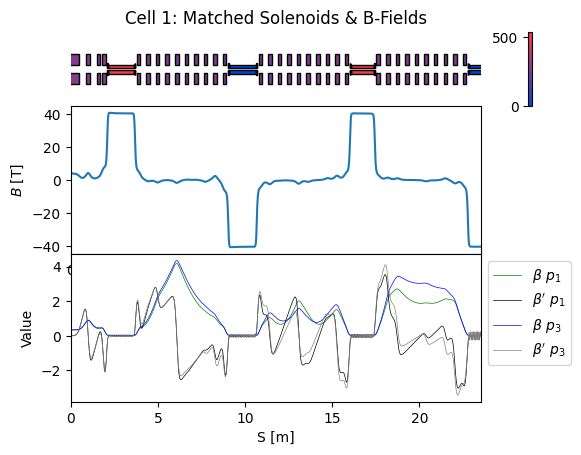

In [100]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure()
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

ncell_match = 3
s_start, s_end = 0, H_solenoid_list[ncell_match].position
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 

p1 = p1_interp(s)
p3 = p3_interp(s)
[beta_interp1, betaP_interp1], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(Mag_field, s, p1, p3)

I_max = H_current_density

max_S = max(s)
max_r = 1

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results


ax3.plot(s, beta_interp1, c='g', lw=0.5, label=r'$\beta \ p_1$')
ax3.plot(s, betaP_interp1, c='k', lw=0.5,label=r'$\beta^{\prime} \ p_1$')
ax3.plot(s, beta_interp3, c='b', lw=0.5, label=r'$\beta \ p_3$')
ax3.plot(s, betaP_interp3, c='grey', lw=0.5,label=r'$\beta^{\prime} \ p_3$')
ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title('Cell 1: Matched Solenoids & B-Fields')
plt.show()

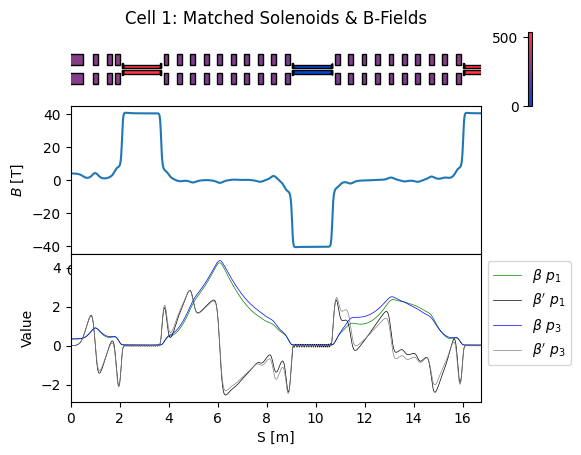

In [ ]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure()
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)


p1 = p1_interp(s)
p3 = p3_interp(s)
[beta_interp1, betaP_interp1], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(Mag_field, s, p1, p3)

I_max = H_current_density
max_S = max(s)
max_r = 1

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results


ax3.plot(s, beta_interp1, c='g', lw=0.5, label=r'$\beta \ p_1$')
ax3.plot(s, betaP_interp1, c='k', lw=0.5,label=r'$\beta^{\prime} \ p_1$')
ax3.plot(s, beta_interp3, c='b', lw=0.5, label=r'$\beta \ p_3$')
ax3.plot(s, betaP_interp3, c='grey', lw=0.5,label=r'$\beta^{\prime} \ p_3$')
ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title('Cell 1: Matched Solenoids & B-Fields')
plt.show()

#### Gif Creation

In [ ]:
def create_gif(gifname):
    m_mu = 0.105658375
    
    coord_arr = ['X [mm]', 'PX [MeV]', 'Y [mm]', 'PY [MeV]', 't [mm/c]', 'E [MeV]']
    index_arr = [1,2,3,4,5,6]
    axes_indices = [[0,1], [0,3], [0,2], [2,1], [2,3], [4,5]]
    coord_indices = [['X', 'Px'], ['X','Py'], ['X','Y'], ['Y','Px'], ['Y','Py'], ['T','Pz']]
    Zunique = sol_df.Z.unique()

    std = 10
    maxes = [sol_df.X.mean()+std*sol_df.X.std(), sol_df.Px.mean()+std*sol_df.Px.std(), sol_df.Y.mean()+std*sol_df.Y.std(), sol_df.Py.mean()+std*sol_df.Py.std()]
    mins =  [sol_df.X.mean()-std*sol_df.X.std(), sol_df.Px.mean()-std*sol_df.Px.std(), sol_df.Y.mean()-std*sol_df.Y.std(), sol_df.Py.mean()-std*sol_df.Py.std()]

    with imageio.get_writer(f"{os.getcwd()}/gifs/{gifname}.gif", mode='I') as writer:
        for z, Z in enumerate(Zunique):
            print(Z, '/', sol_df.Z.max())

            beam = sol_df[sol_df.Z == Z]
            X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
            E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5
            data = np.stack([X, PX, Y, PY, T, E])
            means = np.mean(data, axis=1)
            stds = np.std(data, axis=1)
            # Identify high amplitude particles (above 5 sigma)
            sigma = 5
            filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
            # Filter the data
            filtered_data = data[:, filtered_indices]

            fig = plt.figure(figsize=(12, 4.5))
            gs = fig.add_gridspec(2, 4, width_ratios=[2.5, 1, 1, 1], height_ratios=[1, 1])
            
            # Add subplots to the grid
            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[1, 0])
            ax3 = fig.add_subplot(gs[0, 1])
            ax4 = fig.add_subplot(gs[0, 2])
            ax5 = fig.add_subplot(gs[0, 3])
            ax6 = fig.add_subplot(gs[1, 1])
            ax7 = fig.add_subplot(gs[1, 2])
            ax8 = fig.add_subplot(gs[1, 3])
            
            axes=[ax3,ax4,ax5,ax6,ax7,ax8]

            for i, ax in enumerate(axes):
                ax.set_xlabel(coord_arr[axes_indices[i][0]]), ax.set_ylabel(coord_arr[axes_indices[i][1]])

                scatter = ax.scatter(filtered_data[axes_indices[i][0],:], filtered_data[axes_indices[i][1],:], s=2, c=filtered_data[5], cmap=cmap)
                if i < 5:
                    ax.set(xlim=(mins[axes_indices[i][0]], maxes[axes_indices[i][0]]),
                        ylim=(mins[axes_indices[i][1]], maxes[axes_indices[i][1]]))
                    
            ax1.set_ylabel(r'$\varepsilon_\perp [$ mm]'), ax2.set_ylabel(r'$\varepsilon_\parallel [$ mm]')
            ax2.set_xlabel('S [m]')
            # Remove ticks, labels, and frame from ax10
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            ax3.set_title(f'Position {Z} m')

            ax1.plot(Zunique[:z], np.array(emitT_arr)[:z]*1E6, color='#0046d0')
            ax2.plot(Zunique[:z], np.array(emitL_arr)[:z]*1E3, color='#0046d0')
            ax1.set(xlim=(min(Zunique), max(Zunique)), ylim=(min(np.array(emitT_arr)*1E6), 300), xlabel='S [m]', ylabel=r'$\varepsilon_\perp [$ mm]')
            ax2.set(xlim=(min(Zunique), max(Zunique)), ylim=(min(np.array(emitL_arr)*1E3), 3), xlabel='S [m]', ylabel=r'$\varepsilon_\parallel [$ mm]')
                    
            plt.savefig(f"{os.getcwd()}/gifs/screen_{Z}.png")
            #plt.close(fig)
            image = imageio.imread(f"{os.getcwd()}/gifs/screen_{Z}.png")
            writer.append_data(image)
            os.remove(f"{os.getcwd()}/gifs/screen_{Z}.png")

In [ ]:
import imageio.v2 as imageio
import os


In [ ]:
create_gif('10Cell_Ver0.0')